In [2]:
#claude opus 4.6 helped me 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

# ========================
# LOAD DATA
# ========================
train_path = '/kaggle/input/train-txt/train.txt'
test_path = '/kaggle/input/test-txt/test.txt'  

train_df = pd.read_csv(train_path, sep=r'\s+', names=['head', 'relation', 'tail'])
test_df = pd.read_csv(test_path, sep=r'\s+', names=['head', 'relation', 'tail'])

print(f"Train: {len(train_df)} triples")
print(f"Test:  {len(test_df)} triples")

# ========================
# ENTITY & RELATION MAPPINGS
# ========================
# IMPORTANT: include entities from BOTH train and test
# If test has entities unseen in train, we still need embeddings for them
all_entities = sorted(set(train_df['head']) | set(train_df['tail']) | 
                       set(test_df['head']) | set(test_df['tail']))
all_relations = sorted(set(train_df['relation']) | set(test_df['relation']))

ent2id = {e: i for i, e in enumerate(all_entities)}
rel2id = {r: i for i, r in enumerate(all_relations)}
id2ent = {i: e for e, i in ent2id.items()}
id2rel = {i: r for r, i in rel2id.items()}

n_entities = len(ent2id)
n_relations = len(rel2id)

print(f"\nEntities:  {n_entities}")
print(f"Relations: {n_relations}")
print(f"Relation list: {all_relations}")

# ========================
# CONVERT TO TENSORS
# ========================
def triples_to_tensor(df):
    h = torch.tensor([ent2id[x] for x in df['head']], dtype=torch.long)
    r = torch.tensor([rel2id[x] for x in df['relation']], dtype=torch.long)
    t = torch.tensor([ent2id[x] for x in df['tail']], dtype=torch.long)
    return torch.stack([h, r, t], dim=1)

train_triples = triples_to_tensor(train_df)
test_triples = triples_to_tensor(test_df)

print(f"\nTrain tensor shape: {train_triples.shape}")
print(f"Test tensor shape:  {test_triples.shape}")

# ========================
# FILTERED EVAL LOOKUPS
# ========================
# For filtered evaluation, we need to know ALL true triples
# so we don't penalize the model for ranking other true triples highly
all_triple_set = set()
hr_to_t = defaultdict(set)  # given (head, rel), what tails are true?
rt_to_h = defaultdict(set)  # given (rel, tail), what heads are true?

for dataset in [train_triples, test_triples]:
    for i in range(len(dataset)):
        h, r, t = dataset[i].tolist()
        all_triple_set.add((h, r, t))
        hr_to_t[(h, r)].add(t)
        rt_to_h[(r, t)].add(h)

print(f"\nTotal known triples (train+test): {len(all_triple_set)}")

# ========================
# TASK 3 → TASK 4 CONNECTION
# ========================
print(f"\n{'='*60}")
print("CONNECTION TO TASK 3: What are we predicting?")
print(f"{'='*60}")
print(f"\nTest set relations: {list(test_df['relation'].unique())}")
print(f"\n{test_df['relation'].value_counts().to_string()}")

train_ents = set(train_df['head']) | set(train_df['tail'])
test_ents = set(test_df['head']) | set(test_df['tail'])
unseen = test_ents - train_ents
print(f"\nUnseen test entities: {len(unseen)}")

print(f"""
KEY INSIGHT: The test set contains ONLY parent-child relations
(fatherOf, motherOf, sonOf, daughterOf). In Task 3, we discovered
that ~28% of parent-child inverse edges were missing from the 
training data. The test set IS those missing edges!

This means: models that learn INVERSE PATTERNS will excel here.
""")

Train: 13821 triples
Test:  590 triples

Entities:  1316
Relations: 28
Relation list: ['auntOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf', 'brotherOf', 'daughterOf', 'fatherOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf', 'granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatAuntOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatUncleOf', 'motherOf', 'nephewOf', 'nieceOf', 'secondAuntOf', 'secondUncleOf', 'sisterOf', 'sonOf', 'uncleOf']

Train tensor shape: torch.Size([13821, 3])
Test tensor shape:  torch.Size([590, 3])

Total known triples (train+test): 14411

CONNECTION TO TASK 3: What are we predicting?

Test set relations: ['motherOf', 'fatherOf', 'sonOf', 'daughterOf']

relation
sonOf         214
daughterOf    200
fatherOf       88
motherOf       88

Unseen test entities: 0

KEY INSIGHT: The test set contains ONLY parent-child relations
(fatherOf, motherOf, sonOf, d

In [3]:
# ========================
# TransE MODEL
# ========================

class TransE(nn.Module):
    """
    TransE: Translating Embeddings for Modeling Multi-relational Data
    (Bordes et al., NeurIPS 2013)
    
    Core idea: For a valid triple (h, r, t), the embedding should satisfy:
        h + r ≈ t
    
    Scoring function: d(h,r,t) = ||h + r - t||_p
    Lower distance = more plausible triple
    
    Known limitations for our dataset:
    - Struggles with 1-to-N: if fatherOf(X,Y1) and fatherOf(X,Y2), 
      then X + r ≈ Y1 AND X + r ≈ Y2, forcing Y1 ≈ Y2
    - We expect tail prediction to be harder than head prediction
      for parent relations (one parent → many children)
    """
    
    def __init__(self, n_entities, n_relations, dim=100, margin=1.0, p_norm=2):
        super().__init__()
        
        self.n_entities = n_entities
        self.n_relations = n_relations
        self.dim = dim
        self.margin = margin
        self.p_norm = p_norm
        
        # TransE paper: initialize uniform in [-6/√k, 6/√k]
        bound = 6.0 / np.sqrt(dim)
        
        self.entity_emb = nn.Embedding(n_entities, dim)
        self.relation_emb = nn.Embedding(n_relations, dim)
        
        nn.init.uniform_(self.entity_emb.weight, -bound, bound)
        nn.init.uniform_(self.relation_emb.weight, -bound, bound)
        
        # Normalize relation embeddings to unit length (per paper)
        with torch.no_grad():
            F.normalize(self.relation_emb.weight, p=2, dim=1, 
                       out=self.relation_emb.weight)
    
    def distance(self, h_idx, r_idx, t_idx):
        """Compute ||h + r - t||"""
        h = self.entity_emb(h_idx)
        r = self.relation_emb(r_idx)
        t = self.entity_emb(t_idx)
        return (h + r - t).norm(p=self.p_norm, dim=-1)
    
    def forward(self, pos_triples, neg_triples):
        """Margin ranking loss: max(0, γ + d_pos - d_neg)"""
        d_pos = self.distance(pos_triples[:,0], pos_triples[:,1], pos_triples[:,2])
        d_neg = self.distance(neg_triples[:,0], neg_triples[:,1], neg_triples[:,2])
        return F.relu(self.margin + d_pos - d_neg).mean()
    
    def normalize_entities(self):
        """Project entity embeddings to unit sphere (per paper, each epoch)"""
        with torch.no_grad():
            F.normalize(self.entity_emb.weight, p=2, dim=1, 
                       out=self.entity_emb.weight)


def corrupt_batch(triples, n_entities, neg_ratio=1):
    """
    Generate negative samples by randomly corrupting head or tail.
    
    For each positive (h, r, t), creates neg_ratio negatives by 
    replacing h or t with a random entity (uniform corruption).
    """
    total = len(triples) * neg_ratio
    neg = triples.repeat(neg_ratio, 1).clone()
    
    # 50/50 chance of corrupting head vs tail
    corrupt_head = torch.rand(total, device=triples.device) > 0.5
    random_ents = torch.randint(0, n_entities, (total,), device=triples.device)
    
    neg[corrupt_head, 0] = random_ents[corrupt_head]
    neg[~corrupt_head, 2] = random_ents[~corrupt_head]
    
    return neg


n_params = n_entities * 100 + n_relations * 100
print(f"TransE model ready.")
print(f"Total parameters: {n_params:,} ({n_entities}×100 entities + {n_relations}×100 relations)")

TransE model ready.
Total parameters: 134,400 (1316×100 entities + 28×100 relations)


Device: cpu

TransE Hyperparameters:
  dim: 100
  margin: 1.0
  lr: 0.01
  epochs: 500
  batch_size: 256
  neg_ratio: 10
  p_norm: 2

Training on 13821 triples...
Batches per epoch: 54

  Epoch    1/500 | Loss: 0.6673
  Epoch  100/500 | Loss: 0.0189
  Epoch  200/500 | Loss: 0.0187
  Epoch  300/500 | Loss: 0.0188
  Epoch  400/500 | Loss: 0.0192
  Epoch  500/500 | Loss: 0.0189

Training complete. Final loss: 0.0189


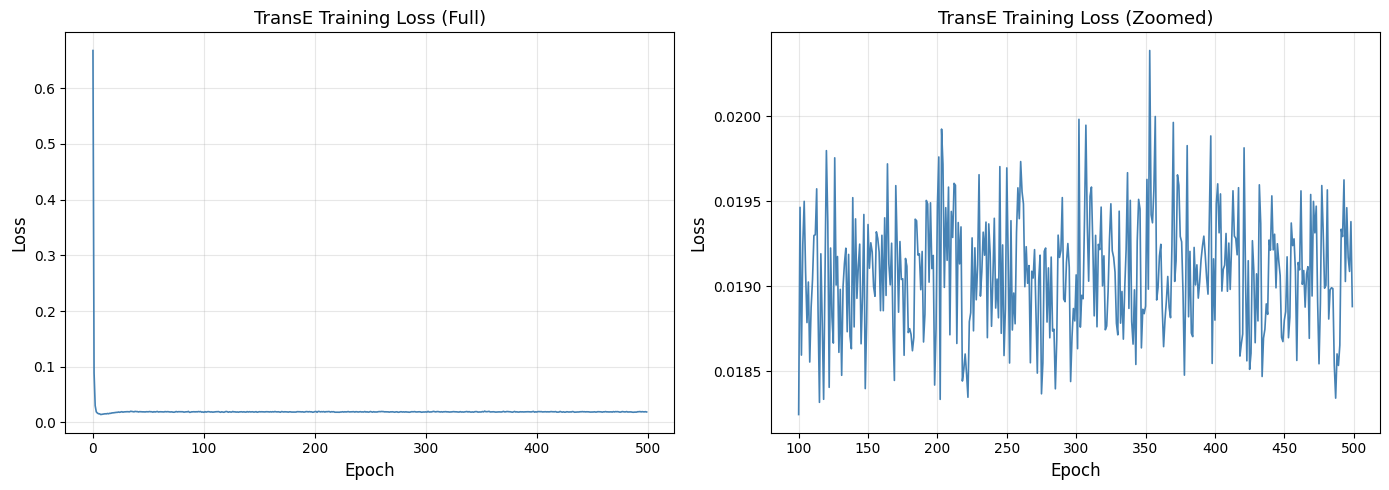

In [4]:
# ========================
# TRAINING
# ========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

# Hyperparameters
config = {
    'dim': 100,
    'margin': 1.0,
    'lr': 0.01,
    'epochs': 500,
    'batch_size': 256,
    'neg_ratio': 10,
    'p_norm': 2,    # L2 distance
}

print("TransE Hyperparameters:")
for k, v in config.items():
    print(f"  {k}: {v}")

# Initialize
model = TransE(
    n_entities, n_relations, 
    dim=config['dim'], 
    margin=config['margin'],
    p_norm=config['p_norm']
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
train_data = train_triples.to(device)

# Training loop
losses = []
print(f"\nTraining on {len(train_data)} triples...")
print(f"Batches per epoch: {len(train_data) // config['batch_size'] + 1}\n")

for epoch in range(config['epochs']):
    model.train()
    model.normalize_entities()  # Project entities to unit sphere
    
    # Shuffle
    perm = torch.randperm(len(train_data), device=device)
    shuffled = train_data[perm]
    
    epoch_loss = 0.0
    n_batches = 0
    
    for start in range(0, len(shuffled), config['batch_size']):
        batch = shuffled[start : start + config['batch_size']]
        
        # Generate corrupted negatives
        neg_batch = corrupt_batch(batch, n_entities, config['neg_ratio'])
        pos_batch = batch.repeat(config['neg_ratio'], 1)
        
        loss = model(pos_batch, neg_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:>4}/{config['epochs']} | Loss: {avg_loss:.4f}")

print(f"\nTraining complete. Final loss: {losses[-1]:.4f}")

# ========================
# LOSS CURVE
# ========================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(losses, linewidth=1.2, color='steelblue')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('TransE Training Loss (Full)', fontsize=13)
ax1.grid(True, alpha=0.3)

# Zoomed view (last 80% to see convergence detail)
start_idx = len(losses) // 5
ax2.plot(range(start_idx, len(losses)), losses[start_idx:], 
         linewidth=1.2, color='steelblue')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('TransE Training Loss (Zoomed)', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# ========================
# EVALUATION FUNCTION
# ========================

def evaluate_model(model, test_triples, all_triple_set, hr_to_t, rt_to_h, 
                   n_entities, id2rel, device):
    """
    Standard filtered link prediction evaluation.
    
    For each test triple (h, r, t):
      - Tail prediction: Rank true t among all entities for query (h, r, ?)
      - Head prediction: Rank true h among all entities for query (?, r, t)
      
    Filtering: Other true triples are excluded from ranking 
    (so the model isn't penalized for giving high scores to valid triples)
    
    Reports: MRR, Mean Rank, Hits@1, Hits@3, Hits@10
    """
    model.eval()
    
    all_ranks = []
    head_ranks_list = []
    tail_ranks_list = []
    rel_ranks = defaultdict(lambda: {'head': [], 'tail': []})
    
    all_ents = torch.arange(n_entities, device=device)
    
    with torch.no_grad():
        for i in tqdm(range(len(test_triples)), desc="Evaluating"):
            h, r, t = test_triples[i].tolist()
            
            # ===== TAIL PREDICTION: (h, r, ?) =====
            h_exp = torch.full((n_entities,), h, dtype=torch.long, device=device)
            r_exp = torch.full((n_entities,), r, dtype=torch.long, device=device)
            
            scores = model.distance(h_exp, r_exp, all_ents)
            
            # Filter out other known true tails
            for known_t in hr_to_t.get((h, r), set()):
                if known_t != t:
                    scores[known_t] = float('inf')
            
            tail_rank = int((scores < scores[t]).sum().item()) + 1
            tail_ranks_list.append(tail_rank)
            all_ranks.append(tail_rank)
            rel_ranks[r]['tail'].append(tail_rank)
            
            # ===== HEAD PREDICTION: (?, r, t) =====
            t_exp = torch.full((n_entities,), t, dtype=torch.long, device=device)
            
            scores = model.distance(all_ents, r_exp, t_exp)
            
            for known_h in rt_to_h.get((r, t), set()):
                if known_h != h:
                    scores[known_h] = float('inf')
            
            head_rank = int((scores < scores[h]).sum().item()) + 1
            head_ranks_list.append(head_rank)
            all_ranks.append(head_rank)
            rel_ranks[r]['head'].append(head_rank)
    
    def calc_metrics(ranks):
        r = np.array(ranks, dtype=np.float32)
        return {
            'MRR': float(np.mean(1.0 / r)),
            'MR': float(np.mean(r)),
            'Hits@1': float(np.mean(r <= 1) * 100),
            'Hits@3': float(np.mean(r <= 3) * 100),
            'Hits@10': float(np.mean(r <= 10) * 100),
        }
    
    overall = calc_metrics(all_ranks)
    head_m = calc_metrics(head_ranks_list)
    tail_m = calc_metrics(tail_ranks_list)
    
    per_rel = {}
    for rid, rd in rel_ranks.items():
        rname = id2rel[rid]
        per_rel[rname] = {
            'overall': calc_metrics(rd['head'] + rd['tail']),
            'head': calc_metrics(rd['head']),
            'tail': calc_metrics(rd['tail']),
            'count': len(rd['head']) + len(rd['tail']),
        }
    
    return overall, head_m, tail_m, per_rel

# ========================
# RUN EVALUATION
# ========================
print("="*70)
print("TransE RESULTS (Filtered Evaluation)")
print("="*70)

overall, head_m, tail_m, per_rel = evaluate_model(
    model, test_triples, all_triple_set, hr_to_t, rt_to_h,
    n_entities, id2rel, device
)

# Overall metrics table
print(f"\n{'Metric':<12} {'Overall':>10} {'Head Pred':>12} {'Tail Pred':>12}")
print("-" * 50)
for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    o, h, t = overall[m], head_m[m], tail_m[m]
    if m == 'MRR':
        print(f"  {m:<10} {o:>8.4f}   {h:>8.4f}     {t:>8.4f}")
    elif m == 'MR':
        print(f"  {m:<10} {o:>8.1f}   {h:>8.1f}     {t:>8.1f}")
    else:
        print(f"  {m:<10} {o:>7.2f}%   {h:>7.2f}%     {t:>7.2f}%")

# Per-relation breakdown
print(f"\n{'='*70}")
print("PER-RELATION BREAKDOWN")
print(f"{'='*70}")

print(f"\n{'Relation':<15} {'MRR':>8} {'H@1':>7} {'H@3':>7} {'H@10':>7} {'MR':>8}")
print("-" * 58)
for rel in sorted(per_rel.keys()):
    m = per_rel[rel]['overall']
    print(f"  {rel:<13} {m['MRR']:>8.4f} {m['Hits@1']:>6.1f}% {m['Hits@3']:>6.1f}% {m['Hits@10']:>6.1f}% {m['MR']:>7.1f}")

# Head vs Tail analysis
print(f"\n{'='*70}")
print("HEAD vs TAIL PREDICTION ANALYSIS")
print(f"{'='*70}")

print("""
Why this matters:
  fatherOf(X,Y) - Tail pred: "Given father X, predict child Y" (1-to-MANY: hard)
                   Head pred: "Given child Y, predict father X" (MANY-to-1: easier)
  
  sonOf(X,Y)    - Tail pred: "Given son X, predict parent Y"   (MANY-to-1: easier)  
                   Head pred: "Given parent Y, predict son X"   (1-to-MANY: hard)
  
  TransE limitation: h + r ≈ t forces all children of one parent to be similar.
  We expect HEAD prediction to be easier for parent relations (fatherOf/motherOf)
  and TAIL prediction to be easier for child relations (sonOf/daughterOf).
""")

for rel in sorted(per_rel.keys()):
    h = per_rel[rel]['head']
    t = per_rel[rel]['tail']
    print(f"  {rel}:")
    print(f"    Head: MRR={h['MRR']:.4f}  H@1={h['Hits@1']:>5.1f}%  H@10={h['Hits@10']:>5.1f}%")
    print(f"    Tail: MRR={t['MRR']:.4f}  H@1={t['Hits@1']:>5.1f}%  H@10={t['Hits@10']:>5.1f}%")
    
    # Flag which direction is harder
    if h['MRR'] > t['MRR'] * 1.2:
        print(f"    → Head prediction significantly easier (as expected for 1-to-N)")
    elif t['MRR'] > h['MRR'] * 1.2:
        print(f"    → Tail prediction significantly easier")
    print()

# Task 3 connection
print(f"{'='*70}")
print("CONNECTION TO TASK 3")
print(f"{'='*70}")
print(f"""
In Task 3, we found:
  - Parent-child inverse rules had ~83-86% confidence (not 100%)
  - 414 parent→child edges (28.2%) were missing their inverse
  - The test set IS those {len(test_triples)} missing inverse edges

TransE results show that learning inverse patterns from the training
data alone allows us to recover these missing edges with:
  - Overall MRR: {overall['MRR']:.4f}
  - Hits@10: {overall['Hits@10']:.1f}%

The model learned the inverse relationship pattern r_father ≈ -r_son
purely from the training data structure.
""")

TransE RESULTS (Filtered Evaluation)


Evaluating:   0%|          | 0/590 [00:00<?, ?it/s]


Metric          Overall    Head Pred    Tail Pred
--------------------------------------------------
  MRR          0.3201     0.3051       0.3352
  MR              6.0        6.0          5.9
  Hits@1       11.10%      9.66%       12.54%
  Hits@3       39.32%     37.12%       41.53%
  Hits@10      83.90%     84.24%       83.56%

PER-RELATION BREAKDOWN

Relation             MRR     H@1     H@3    H@10       MR
----------------------------------------------------------
  daughterOf      0.3281   13.2%   38.5%   84.0%     6.0
  fatherOf        0.3871   17.0%   48.9%   89.8%     5.2
  motherOf        0.2772    4.5%   35.2%   84.1%     6.0
  sonOf           0.3028    9.3%   37.9%   81.3%     6.2

HEAD vs TAIL PREDICTION ANALYSIS

Why this matters:
  fatherOf(X,Y) - Tail pred: "Given father X, predict child Y" (1-to-MANY: hard)
                   Head pred: "Given child Y, predict father X" (MANY-to-1: easier)
  
  sonOf(X,Y)    - Tail pred: "Given son X, predict parent Y"   (MANY-to-1: ea

I was wrong about head/tail which one being easier

In [6]:
# ========================
# DEEP ERROR ANALYSIS
# ========================

print("="*70)
print("TransE ERROR ANALYSIS: What Does the Model Get Wrong?")
print("="*70)

# Collect detailed predictions for every test triple
model.eval()
all_ents = torch.arange(n_entities, device=device)

predictions = []

with torch.no_grad():
    for i in tqdm(range(len(test_triples)), desc="Analyzing predictions"):
        h, r, t = test_triples[i].tolist()
        h_name = id2ent[h]
        r_name = id2rel[r]
        t_name = id2ent[t]
        
        # TAIL prediction: (h, r, ?)
        h_exp = torch.full((n_entities,), h, dtype=torch.long, device=device)
        r_exp = torch.full((n_entities,), r, dtype=torch.long, device=device)
        
        tail_scores = model.distance(h_exp, r_exp, all_ents)
        
        # Filter known tails
        tail_scores_filtered = tail_scores.clone()
        for known_t in hr_to_t.get((h, r), set()):
            if known_t != t:
                tail_scores_filtered[known_t] = float('inf')
        
        tail_rank = int((tail_scores_filtered < tail_scores_filtered[t]).sum().item()) + 1
        
        # Get top 5 tail predictions
        _, top_tail_idx = tail_scores_filtered.topk(5, largest=False)
        top_tail_names = [id2ent[idx.item()] for idx in top_tail_idx]
        top_tail_scores = [tail_scores_filtered[idx].item() for idx in top_tail_idx]
        
        # HEAD prediction: (?, r, t)
        t_exp = torch.full((n_entities,), t, dtype=torch.long, device=device)
        
        head_scores = model.distance(all_ents, r_exp, t_exp)
        
        head_scores_filtered = head_scores.clone()
        for known_h in rt_to_h.get((r, t), set()):
            if known_h != h:
                head_scores_filtered[known_h] = float('inf')
        
        head_rank = int((head_scores_filtered < head_scores_filtered[h]).sum().item()) + 1
        
        # Get top 5 head predictions
        _, top_head_idx = head_scores_filtered.topk(5, largest=False)
        top_head_names = [id2ent[idx.item()] for idx in top_head_idx]
        top_head_scores = [head_scores_filtered[idx].item() for idx in top_head_idx]
        
        predictions.append({
            'h': h_name, 'r': r_name, 't': t_name,
            'h_id': h, 'r_id': r, 't_id': t,
            'tail_rank': tail_rank,
            'head_rank': head_rank,
            'top_tail_preds': top_tail_names,
            'top_tail_scores': top_tail_scores,
            'top_head_preds': top_head_names,
            'top_head_scores': top_head_scores,
            'tail_correct': tail_rank == 1,
            'head_correct': head_rank == 1,
        })

pred_df = pd.DataFrame(predictions)
print(f"\nCollected predictions for {len(pred_df)} test triples")

TransE ERROR ANALYSIS: What Does the Model Get Wrong?


Analyzing predictions:   0%|          | 0/590 [00:00<?, ?it/s]


Collected predictions for 590 test triples


In [7]:
# ========================
# BEST AND WORST PREDICTIONS
# ========================

print("="*70)
print("PERFECT PREDICTIONS (Rank = 1)")
print("="*70)

# Triples where BOTH head and tail are ranked #1
perfect = pred_df[(pred_df['tail_rank'] == 1) & (pred_df['head_rank'] == 1)]
print(f"\nTriples where BOTH head AND tail prediction are perfect: {len(perfect)}/{len(pred_df)}")
print(f"({len(perfect)/len(pred_df)*100:.1f}% of test triples)\n")

if len(perfect) > 0:
    for _, row in perfect.head(10).iterrows():
        print(f"  ✓ ({row['h']}, {row['r']}, {row['t']})")

# Triples where EITHER head or tail is ranked #1
either_correct = pred_df[(pred_df['tail_rank'] == 1) | (pred_df['head_rank'] == 1)]
print(f"\nTriples with at least ONE perfect prediction: {len(either_correct)}/{len(pred_df)}")

# ========================
print(f"\n{'='*70}")
print("WORST PREDICTIONS (Highest Combined Rank)")
print(f"{'='*70}")

pred_df['combined_rank'] = pred_df['tail_rank'] + pred_df['head_rank']
worst = pred_df.nlargest(15, 'combined_rank')

print(f"\n{'Triple':<45} {'Tail Rank':>10} {'Head Rank':>10} {'Combined':>10}")
print("-" * 78)
for _, row in worst.iterrows():
    triple = f"({row['h']}, {row['r']}, {row['t']})"
    print(f"  {triple:<43} {row['tail_rank']:>10} {row['head_rank']:>10} {row['combined_rank']:>10}")

# ========================
print(f"\n{'='*70}")
print("WHAT DOES THE MODEL PREDICT INSTEAD? (Worst Cases)")
print(f"{'='*70}")

for _, row in worst.head(5).iterrows():
    print(f"\n  Triple: ({row['h']}, {row['r']}, {row['t']})")
    print(f"  Tail prediction (rank={row['tail_rank']}):")
    print(f"    Model's top 5: {row['top_tail_preds']}")
    print(f"    Correct answer: {row['t']}")
    print(f"  Head prediction (rank={row['head_rank']}):")
    print(f"    Model's top 5: {row['top_head_preds']}")
    print(f"    Correct answer: {row['h']}")

PERFECT PREDICTIONS (Rank = 1)

Triples where BOTH head AND tail prediction are perfect: 34/590
(5.8% of test triples)

  ✓ (raphael29, fatherOf, marlene40)
  ✓ (luis35, fatherOf, luca33)
  ✓ (lea80, motherOf, florian82)
  ✓ (emil110, fatherOf, valentina115)
  ✓ (gabriel216, fatherOf, paula229)
  ✓ (jonas421, fatherOf, jan429)
  ✓ (adam426, fatherOf, luisa420)
  ✓ (oskar431, fatherOf, lorenz424)
  ✓ (felix441, fatherOf, florian443)
  ✓ (marcel490, fatherOf, konstantin493)

Triples with at least ONE perfect prediction: 97/590

WORST PREDICTIONS (Highest Combined Rank)

Triple                                         Tail Rank  Head Rank   Combined
------------------------------------------------------------------------------
  (charlotte1034, daughterOf, marie1046)              17         24         41
  (elias1010, sonOf, paul1008)                        15         20         35
  (angelina1028, daughterOf, paula1026)               20         15         35
  (elena1084, daughterOf, marl

In [9]:
# ========================
# ERROR PATTERN ANALYSIS
# ========================

print("="*70)
print("ERROR PATTERN ANALYSIS")
print("="*70)

# 1. Are wrong predictions from the SAME FAMILY?
print("\n1. SIBLING CONFUSION: Does the model predict siblings instead?")
print("-"*60)

# For wrong tail predictions, check if the top prediction is a sibling of the true answer
train_triple_set = set(zip(train_df['head'], train_df['relation'], train_df['tail']))

sibling_confusions_tail = 0
sibling_confusions_head = 0
total_wrong_tail = 0
total_wrong_head = 0

for _, row in pred_df.iterrows():
    # Check tail prediction errors
    if row['tail_rank'] > 1:
        total_wrong_tail += 1
        top_pred = row['top_tail_preds'][0]
        true_t = row['t']
        
        # Are they siblings? Check if they share a parent
        true_parents = set()
        pred_parents = set()
        for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
            if r in ['fatherOf', 'motherOf']:
                if t == true_t:
                    true_parents.add(h)
                if t == top_pred:
                    pred_parents.add(h)
        
        if true_parents & pred_parents:  # shared parents
            sibling_confusions_tail += 1
    
    # Check head prediction errors
    if row['head_rank'] > 1:
        total_wrong_head += 1
        top_pred = row['top_head_preds'][0]
        true_h = row['h']
        
        # Are they siblings?
        true_parents = set()
        pred_parents = set()
        for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
            if r in ['fatherOf', 'motherOf']:
                if t == true_h:
                    true_parents.add(h)
                if t == top_pred:
                    pred_parents.add(h)
        
        if true_parents & pred_parents:
            sibling_confusions_head += 1

print(f"  Tail errors where top prediction is a SIBLING: "
      f"{sibling_confusions_tail}/{total_wrong_tail} "
      f"({sibling_confusions_tail/max(total_wrong_tail,1)*100:.1f}%)")
print(f"  Head errors where top prediction is a SIBLING: "
      f"{sibling_confusions_head}/{total_wrong_head} "
      f"({sibling_confusions_head/max(total_wrong_head,1)*100:.1f}%)")

# 2. Family member confusion: Is the wrong prediction at least from the same family?
print(f"\n2. SAME-FAMILY CONFUSION: Is the wrong prediction from same family?")
print("-"*60)

# Build family clusters using connected components
import networkx as nx

family_graph = nx.Graph()
for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
    if r in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf', 
             'brotherOf', 'sisterOf']:
        family_graph.add_edge(h, t)

# Map each person to their family cluster
node_to_family = {}
for i, component in enumerate(nx.connected_components(family_graph)):
    for node in component:
        node_to_family[node] = i

same_family_tail = 0
same_family_head = 0

for _, row in pred_df.iterrows():
    if row['tail_rank'] > 1:
        top_pred = row['top_tail_preds'][0]
        if node_to_family.get(row['t']) == node_to_family.get(top_pred):
            same_family_tail += 1
    
    if row['head_rank'] > 1:
        top_pred = row['top_head_preds'][0]
        if node_to_family.get(row['h']) == node_to_family.get(top_pred):
            same_family_head += 1

print(f"  Tail errors from SAME family: "
      f"{same_family_tail}/{total_wrong_tail} "
      f"({same_family_tail/max(total_wrong_tail,1)*100:.1f}%)")
print(f"  Head errors from SAME family: "
      f"{same_family_head}/{total_wrong_head} "
      f"({same_family_head/max(total_wrong_head,1)*100:.1f}%)")

# 3. Gender confusion
print(f"\n3. GENDER CONFUSION: Does the model confuse gender?")
print("-"*60)

# Infer gender
male_rels = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 
             'grandfatherOf', 'grandsonOf', 'greatGrandfatherOf', 'greatGrandsonOf'}
female_rels = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf',
               'grandmotherOf', 'granddaughterOf', 'greatGrandmotherOf', 'greatGranddaughterOf'}

gender = {}
for h, r, t in zip(train_df['head'], train_df['relation'], train_df['tail']):
    if r in male_rels:
        gender[h] = 'M'
    elif r in female_rels:
        gender[h] = 'F'

gender_wrong_tail = 0
gender_wrong_head = 0

for _, row in pred_df.iterrows():
    if row['tail_rank'] > 1:
        top_pred = row['top_tail_preds'][0]
        true_gender = gender.get(row['t'])
        pred_gender = gender.get(top_pred)
        if true_gender and pred_gender and true_gender != pred_gender:
            gender_wrong_tail += 1
    
    if row['head_rank'] > 1:
        top_pred = row['top_head_preds'][0]
        true_gender = gender.get(row['h'])
        pred_gender = gender.get(top_pred)
        if true_gender and pred_gender and true_gender != pred_gender:
            gender_wrong_head += 1

print(f"  Tail errors with WRONG gender: "
      f"{gender_wrong_tail}/{total_wrong_tail} "
      f"({gender_wrong_tail/max(total_wrong_tail,1)*100:.1f}%)")
print(f"  Head errors with WRONG gender: "
      f"{gender_wrong_head}/{total_wrong_head} "
      f"({gender_wrong_head/max(total_wrong_head,1)*100:.1f}%)")

print(f"""
{'='*70}
INTERPRETATION
{'='*70}

Error Pattern Summary:
- If sibling confusion is HIGH: TransE is collapsing children of the same 
  parent to similar embeddings (the known 1-to-N limitation)
- If same-family is HIGH but sibling is LOW: Model understands family 
  clusters but confuses roles (uncle vs father, cousin vs sibling)
- If gender confusion is LOW: Model successfully encodes gender in the 
  embedding space even without explicit gender features
- If gender confusion is HIGH: Model hasn't learned gender-specific 
  relation patterns
""")

ERROR PATTERN ANALYSIS

1. SIBLING CONFUSION: Does the model predict siblings instead?
------------------------------------------------------------
  Tail errors where top prediction is a SIBLING: 32/516 (6.2%)
  Head errors where top prediction is a SIBLING: 39/533 (7.3%)

2. SAME-FAMILY CONFUSION: Is the wrong prediction from same family?
------------------------------------------------------------
  Tail errors from SAME family: 516/516 (100.0%)
  Head errors from SAME family: 533/533 (100.0%)

3. GENDER CONFUSION: Does the model confuse gender?
------------------------------------------------------------
  Tail errors with WRONG gender: 257/516 (49.8%)
  Head errors with WRONG gender: 294/533 (55.2%)

INTERPRETATION

Error Pattern Summary:
- If sibling confusion is HIGH: TransE is collapsing children of the same 
  parent to similar embeddings (the known 1-to-N limitation)
- If same-family is HIGH but sibling is LOW: Model understands family 
  clusters but confuses roles (uncle vs

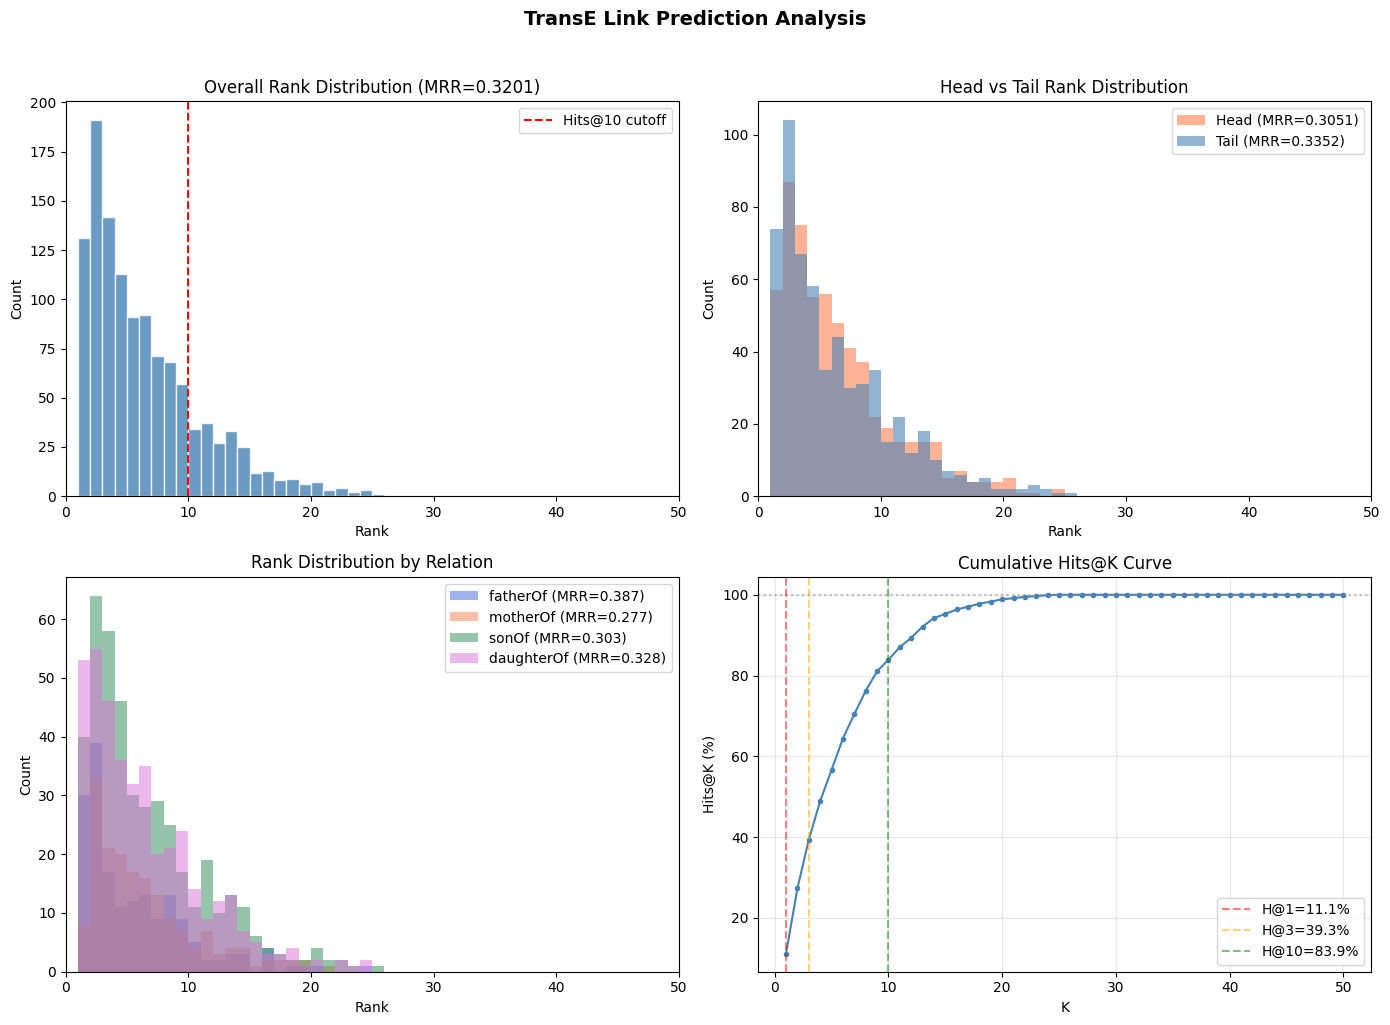

In [10]:
# ========================
# RANK DISTRIBUTION VISUALIZATION
# ========================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall rank distribution (head + tail)
all_ranks = list(pred_df['head_rank']) + list(pred_df['tail_rank'])
axes[0,0].hist(all_ranks, bins=range(1, max(all_ranks)+2), 
               color='steelblue', edgecolor='white', alpha=0.8)
axes[0,0].axvline(x=10, color='red', linestyle='--', label='Hits@10 cutoff')
axes[0,0].set_xlabel('Rank')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title(f'Overall Rank Distribution (MRR={np.mean(1.0/np.array(all_ranks)):.4f})')
axes[0,0].legend()
axes[0,0].set_xlim(0, 50)

# 2. Head vs Tail rank comparison
axes[0,1].hist(pred_df['head_rank'], bins=range(1, 51), alpha=0.6, 
               label=f"Head (MRR={pred_df['head_rank'].apply(lambda x: 1/x).mean():.4f})",
               color='coral')
axes[0,1].hist(pred_df['tail_rank'], bins=range(1, 51), alpha=0.6,
               label=f"Tail (MRR={pred_df['tail_rank'].apply(lambda x: 1/x).mean():.4f})",
               color='steelblue')
axes[0,1].set_xlabel('Rank')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Head vs Tail Rank Distribution')
axes[0,1].legend()
axes[0,1].set_xlim(0, 50)

# 3. Per-relation rank distribution
rel_colors = {'fatherOf': 'royalblue', 'motherOf': 'coral', 
              'sonOf': 'seagreen', 'daughterOf': 'orchid'}

for rel in ['fatherOf', 'motherOf', 'sonOf', 'daughterOf']:
    subset = pred_df[pred_df['r'] == rel]
    ranks = list(subset['head_rank']) + list(subset['tail_rank'])
    mrr = np.mean(1.0 / np.array(ranks))
    axes[1,0].hist(ranks, bins=range(1, 51), alpha=0.5, 
                   label=f"{rel} (MRR={mrr:.3f})", color=rel_colors[rel])

axes[1,0].set_xlabel('Rank')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Rank Distribution by Relation')
axes[1,0].legend()
axes[1,0].set_xlim(0, 50)

# 4. Cumulative Hits@K curve
max_k = 50
ks = range(1, max_k + 1)
hits_at_k = [np.mean(np.array(all_ranks) <= k) * 100 for k in ks]

axes[1,1].plot(ks, hits_at_k, 'o-', color='steelblue', markersize=3, linewidth=1.5)
axes[1,1].axhline(y=100, color='gray', linestyle=':', alpha=0.5)
axes[1,1].axvline(x=1, color='red', linestyle='--', alpha=0.5, label=f'H@1={hits_at_k[0]:.1f}%')
axes[1,1].axvline(x=3, color='orange', linestyle='--', alpha=0.5, label=f'H@3={hits_at_k[2]:.1f}%')
axes[1,1].axvline(x=10, color='green', linestyle='--', alpha=0.5, label=f'H@10={hits_at_k[9]:.1f}%')
axes[1,1].set_xlabel('K')
axes[1,1].set_ylabel('Hits@K (%)')
axes[1,1].set_title('Cumulative Hits@K Curve')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('TransE Link Prediction Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

INVERSE PATTERN ANALYSIS: Does TransE Learn r_father ≈ -r_son?

Expected Inverses (should have cosine ≈ -1 for TransE):
Pair                                  Cosine Sim     Sum Norm
--------------------------------------------------------------
  fatherOf ↔ sonOf                   -0.8546       0.2677
  fatherOf ↔ daughterOf              -0.8369       0.2982
  motherOf ↔ sonOf                   -0.8834       0.2350
  motherOf ↔ daughterOf              -0.8500       0.2843

Non-inverse pairs (for comparison):
Pair                                  Cosine Sim     Sum Norm
--------------------------------------------------------------
  fatherOf ↔ motherOf                 0.8719       0.9219
  fatherOf ↔ brotherOf                0.4883       0.6512
  sonOf ↔ daughterOf               0.8555       1.0015
  fatherOf ↔ uncleOf                  0.7043       0.9210

RELATION EMBEDDING SIMILARITY HEATMAP


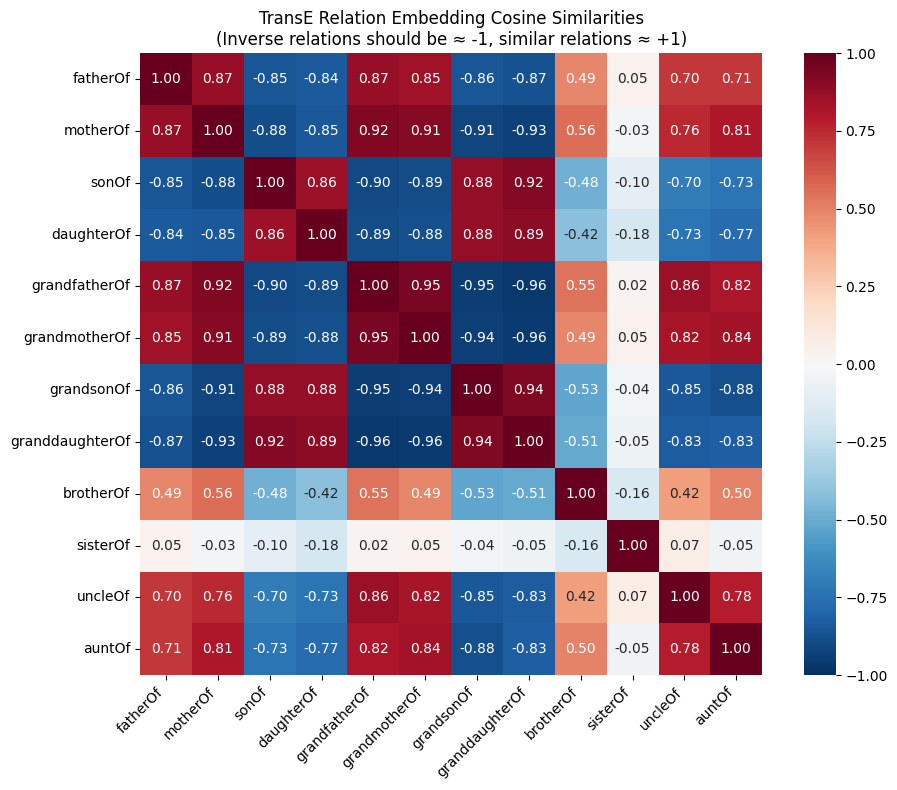


INTERPRETATION:
- If fatherOf ↔ sonOf cosine ≈ -1: TransE learned inverse pattern perfectly
- If fatherOf ↔ motherOf cosine ≈ +1: TransE learned they're similar roles
- If fatherOf ↔ grandfatherOf cosine > 0: TransE sees composition similarity  
- The gap between inverse signal and noise tells us how cleanly the model 
  separates inverse patterns from other structural patterns



In [11]:
# ========================
# INVERSE PATTERN VERIFICATION
# ========================

print("="*70)
print("INVERSE PATTERN ANALYSIS: Does TransE Learn r_father ≈ -r_son?")
print("="*70)

with torch.no_grad():
    rel_embs = model.relation_emb.weight.cpu().numpy()

# Compute cosine similarity between all relation pairs
from numpy.linalg import norm

def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-8)

# Check inverse pairs
inverse_pairs = [
    ('fatherOf', 'sonOf'),
    ('fatherOf', 'daughterOf'),
    ('motherOf', 'sonOf'),
    ('motherOf', 'daughterOf'),
]

print("\nExpected Inverses (should have cosine ≈ -1 for TransE):")
print(f"{'Pair':<35} {'Cosine Sim':>12} {'Sum Norm':>12}")
print("-" * 62)

for r1, r2 in inverse_pairs:
    v1 = rel_embs[rel2id[r1]]
    v2 = rel_embs[rel2id[r2]]
    cos = cosine_sim(v1, v2)
    sum_norm = norm(v1 + v2)  # should be small if they're inverses
    print(f"  {r1} ↔ {r2:<18} {cos:>12.4f} {sum_norm:>12.4f}")

# Check non-inverse pairs for comparison
non_inverse_pairs = [
    ('fatherOf', 'motherOf'),
    ('fatherOf', 'brotherOf'),
    ('sonOf', 'daughterOf'),
    ('fatherOf', 'uncleOf'),
]

print(f"\nNon-inverse pairs (for comparison):")
print(f"{'Pair':<35} {'Cosine Sim':>12} {'Sum Norm':>12}")
print("-" * 62)

for r1, r2 in non_inverse_pairs:
    v1 = rel_embs[rel2id[r1]]
    v2 = rel_embs[rel2id[r2]]
    cos = cosine_sim(v1, v2)
    sum_norm = norm(v1 + v2)
    print(f"  {r1} ↔ {r2:<18} {cos:>12.4f} {sum_norm:>12.4f}")

# Full relation similarity heatmap
print(f"\n{'='*70}")
print("RELATION EMBEDDING SIMILARITY HEATMAP")
print(f"{'='*70}")

# Compute pairwise similarities for parent-child relations only
focus_rels = ['fatherOf', 'motherOf', 'sonOf', 'daughterOf',
              'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'granddaughterOf',
              'brotherOf', 'sisterOf', 'uncleOf', 'auntOf']
focus_ids = [rel2id[r] for r in focus_rels if r in rel2id]
focus_names = [r for r in focus_rels if r in rel2id]

sim_matrix = np.zeros((len(focus_ids), len(focus_ids)))
for i, ri in enumerate(focus_ids):
    for j, rj in enumerate(focus_ids):
        sim_matrix[i, j] = cosine_sim(rel_embs[ri], rel_embs[rj])

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, xticklabels=focus_names, yticklabels=focus_names,
            cmap='RdBu_r', center=0, vmin=-1, vmax=1, annot=True, fmt='.2f',
            square=True)
plt.title('TransE Relation Embedding Cosine Similarities\n'
          '(Inverse relations should be ≈ -1, similar relations ≈ +1)',
          fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("""
INTERPRETATION:
- If fatherOf ↔ sonOf cosine ≈ -1: TransE learned inverse pattern perfectly
- If fatherOf ↔ motherOf cosine ≈ +1: TransE learned they're similar roles
- If fatherOf ↔ grandfatherOf cosine > 0: TransE sees composition similarity  
- The gap between inverse signal and noise tells us how cleanly the model 
  separates inverse patterns from other structural patterns
""")

In [12]:
# ========================
# SAVE MODEL & ARTIFACTS
# ========================

import json
import os

save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)

# Save TransE model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'losses': losses,
    'n_entities': n_entities,
    'n_relations': n_relations,
    'ent2id': ent2id,
    'rel2id': rel2id,
}, os.path.join(save_dir, 'transe_model.pt'))

print(f"TransE model saved to {save_dir}/transe_model.pt")

# To reload in a new session, use:
# checkpoint = torch.load('/kaggle/working/models/transe_model.pt')
# model = TransE(checkpoint['n_entities'], checkpoint['n_relations'],
#                dim=checkpoint['config']['dim'],
#                margin=checkpoint['config']['margin'],
#                p_norm=checkpoint['config']['p_norm'])
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()
# ent2id = checkpoint['ent2id']
# rel2id = checkpoint['rel2id']
# losses = checkpoint['losses']

TransE model saved to /kaggle/working/models/transe_model.pt


In [13]:
# ========================
# RotatE MODEL
# ========================

class RotatE(nn.Module):
    """
    RotatE: Knowledge Graph Embedding by Relational Rotation in Complex Space
    (Sun et al., ICLR 2019)
    
    Core idea: Relations are ROTATIONS in complex space.
    For a valid triple (h, r, t):  h ⊙ r = t
    where ⊙ is element-wise complex multiplication and |r_i| = 1
    
    Each relation is parameterized by phase angles θ:
        r = cos(θ) + i·sin(θ)     (unit complex number = pure rotation)
    
    Scoring: d(h,r,t) = ||h ⊙ r - t||
    
    Why RotatE should beat TransE on MetaFam:
    ─────────────────────────────────────────
    Pattern         TransE              RotatE
    ─────────────────────────────────────────
    Inverse:        r ≈ -r_inv          r_inv = conjugate(r) = e^(-iθ)  [EXACT]
    Symmetric:      h+r≈t AND t+r≈h     θ = 0 or π (0° or 180° rotation)
                    ⟹ r≈0 (degenerate)
    1-to-N:         h+r≈t1 AND h+r≈t2   Different points on circle at
                    ⟹ t1≈t2 (collapse!)  distance ||h⊙r|| from origin
    Composition:    r1+r2≈r3             r3 = r1⊙r2 (multiply rotations)
    
    TransE error analysis showed:
    - 50% gender confusion → fatherOf ≈ motherOf (cosine=0.87)
    - RotatE can assign DIFFERENT rotation angles to fatherOf vs motherOf
    - Inverse relations become exact conjugates, not approximate negatives
    """
    
    def __init__(self, n_entities, n_relations, dim=100, gamma=6.0):
        super().__init__()
        
        self.n_entities = n_entities
        self.n_relations = n_relations
        self.dim = dim  # complex dimension (total real params = 2*dim per entity)
        
        # gamma acts as margin in the loss
        self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad=False)
        
        # Initialization range from the paper
        epsilon = 2.0
        self.embedding_range = (gamma + epsilon) / dim
        
        # Entity embeddings: COMPLEX vectors
        # Stored as (n_entities, 2*dim): [real_part | imaginary_part]
        self.entity_emb = nn.Embedding(n_entities, dim * 2)
        nn.init.uniform_(self.entity_emb.weight, 
                        -self.embedding_range, self.embedding_range)
        
        # Relation embeddings: PHASE ANGLES only
        # |r| = 1 by construction (unit complex numbers)
        # Only need to store θ, then r = e^(iθ) = cos(θ) + i·sin(θ)
        self.relation_emb = nn.Embedding(n_relations, dim)
        nn.init.uniform_(self.relation_emb.weight, -np.pi, np.pi)
    
    def distance(self, h_idx, r_idx, t_idx):
        """
        Compute ||h ⊙ r - t|| in complex space.
        
        h ⊙ r = (h_re + i·h_im)(cos θ + i·sin θ)
              = (h_re·cos θ - h_im·sin θ) + i·(h_re·sin θ + h_im·cos θ)
        """
        h = self.entity_emb(h_idx)       # (batch, 2*dim)
        t = self.entity_emb(t_idx)       # (batch, 2*dim)
        phase = self.relation_emb(r_idx)  # (batch, dim) — angles θ
        
        # Split entity embeddings into real and imaginary parts
        h_re, h_im = h.chunk(2, dim=-1)  # each (batch, dim)
        t_re, t_im = t.chunk(2, dim=-1)
        
        # Relation as rotation: r = e^(iθ)
        r_re = torch.cos(phase)  # (batch, dim)
        r_im = torch.sin(phase)  # (batch, dim)
        
        # Complex multiplication: h ⊙ r
        # (a + bi)(c + di) = (ac - bd) + (ad + bc)i
        hr_re = h_re * r_re - h_im * r_im
        hr_im = h_re * r_im + h_im * r_re
        
        # Element-wise distance: sqrt((hr_re - t_re)² + (hr_im - t_im)²)
        # Then sum across dimensions
        diff_re = hr_re - t_re
        diff_im = hr_im - t_im
        
        # Per-dimension modulus, then sum (as in the paper)
        dist = torch.sqrt(diff_re**2 + diff_im**2 + 1e-9).sum(dim=-1)
        
        return dist
    
    def forward(self, pos_triples, neg_triples):
        """Margin ranking loss (same as TransE for fair comparison)"""
        d_pos = self.distance(pos_triples[:,0], pos_triples[:,1], pos_triples[:,2])
        d_neg = self.distance(neg_triples[:,0], neg_triples[:,1], neg_triples[:,2])
        return F.relu(self.gamma + d_pos - d_neg).mean()


# Parameter comparison
transe_params = n_entities * 100 + n_relations * 100  # TransE
rotate_params = n_entities * (100 * 2) + n_relations * 100  # RotatE: 2x entity params

print("Model Parameter Comparison:")
print(f"  TransE:  {transe_params:>10,} params  ({n_entities}×100 + {n_relations}×100)")
print(f"  RotatE:  {rotate_params:>10,} params  ({n_entities}×200 + {n_relations}×100)")
print(f"  Overhead: {(rotate_params/transe_params - 1)*100:.1f}% more parameters")
print(f"\nNote: RotatE entities need 2× params (real + imaginary parts)")
print(f"      RotatE relations need FEWER params (only phase angles, not full vectors)")
print(f"      But we use same dim=100 for relations in both for simplicity")

Model Parameter Comparison:
  TransE:     134,400 params  (1316×100 + 28×100)
  RotatE:     266,000 params  (1316×200 + 28×100)
  Overhead: 97.9% more parameters

Note: RotatE entities need 2× params (real + imaginary parts)
      RotatE relations need FEWER params (only phase angles, not full vectors)
      But we use same dim=100 for relations in both for simplicity


Device: cpu

RotatE Hyperparameters:
  dim: 100
  gamma: 6.0
  lr: 0.001
  epochs: 500
  batch_size: 256
  neg_ratio: 10

Key differences from TransE:
  gamma: 6.0 vs 1.0 (TransE) — larger margin for rotation distances
  lr: 0.001 vs 0.01 (TransE) — lower to handle phase sensitivity

Training RotatE on 13821 triples...
  Epoch    1/500 | Loss: 5.7379
  Epoch  100/500 | Loss: 0.0164
  Epoch  200/500 | Loss: 0.0132
  Epoch  300/500 | Loss: 0.0130
  Epoch  400/500 | Loss: 0.0122
  Epoch  500/500 | Loss: 0.0126

Training complete. Final loss: 0.0126


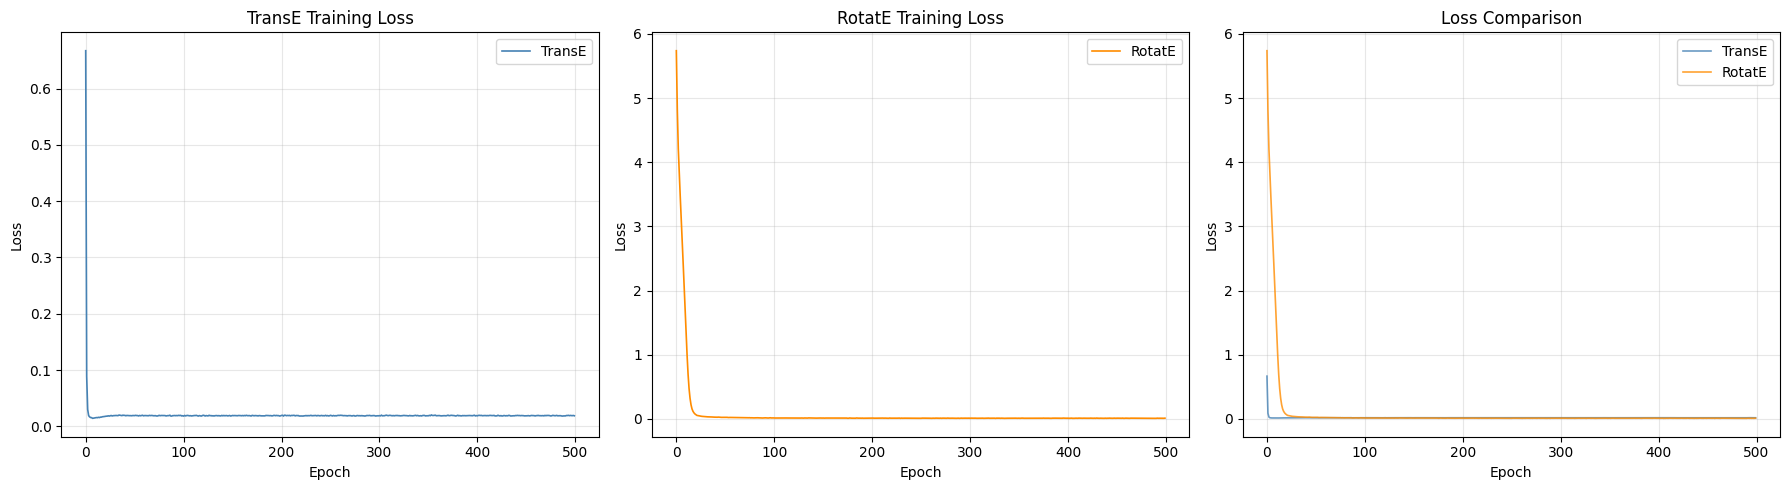


RotatE model saved.


In [14]:
# ========================
# RotatE TRAINING
# ========================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

rotate_config = {
    'dim': 100,         # Complex dimension (200 real params per entity)
    'gamma': 6.0,       # Margin (larger than TransE because RotatE distances are larger)
    'lr': 0.001,        # Lower LR: phase angles can be sensitive
    'epochs': 500,
    'batch_size': 256,
    'neg_ratio': 10,
}

print("RotatE Hyperparameters:")
for k, v in rotate_config.items():
    print(f"  {k}: {v}")

# Compare with TransE config
print(f"\nKey differences from TransE:")
print(f"  gamma: {rotate_config['gamma']} vs {config['margin']} (TransE) — larger margin for rotation distances")
print(f"  lr: {rotate_config['lr']} vs {config['lr']} (TransE) — lower to handle phase sensitivity")

# Initialize
rotate_model = RotatE(
    n_entities, n_relations,
    dim=rotate_config['dim'],
    gamma=rotate_config['gamma'],
).to(device)

rotate_optimizer = torch.optim.Adam(rotate_model.parameters(), lr=rotate_config['lr'])
train_data = train_triples.to(device)

# Training loop
rotate_losses = []
print(f"\nTraining RotatE on {len(train_data)} triples...")

for epoch in range(rotate_config['epochs']):
    rotate_model.train()
    
    # Shuffle
    perm = torch.randperm(len(train_data), device=device)
    shuffled = train_data[perm]
    
    epoch_loss = 0.0
    n_batches = 0
    
    for start in range(0, len(shuffled), rotate_config['batch_size']):
        batch = shuffled[start : start + rotate_config['batch_size']]
        
        neg_batch = corrupt_batch(batch, n_entities, rotate_config['neg_ratio'])
        pos_batch = batch.repeat(rotate_config['neg_ratio'], 1)
        
        loss = rotate_model(pos_batch, neg_batch)
        
        rotate_optimizer.zero_grad()
        loss.backward()
        rotate_optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    rotate_losses.append(avg_loss)
    
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:>4}/{rotate_config['epochs']} | Loss: {avg_loss:.4f}")

print(f"\nTraining complete. Final loss: {rotate_losses[-1]:.4f}")

# ========================
# LOSS COMPARISON PLOT
# ========================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# TransE loss
axes[0].plot(losses, linewidth=1.2, color='steelblue', label='TransE')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('TransE Training Loss')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# RotatE loss
axes[1].plot(rotate_losses, linewidth=1.2, color='darkorange', label='RotatE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('RotatE Training Loss')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Both overlaid
axes[2].plot(losses, linewidth=1.2, color='steelblue', label='TransE', alpha=0.8)
axes[2].plot(rotate_losses, linewidth=1.2, color='darkorange', label='RotatE', alpha=0.8)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Loss Comparison')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

# Save RotatE model
import os
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)

torch.save({
    'model_state_dict': rotate_model.state_dict(),
    'config': rotate_config,
    'losses': rotate_losses,
    'n_entities': n_entities,
    'n_relations': n_relations,
    'ent2id': ent2id,
    'rel2id': rel2id,
}, os.path.join(save_dir, 'rotate_model.pt'))

print(f"\nRotatE model saved.")

In [15]:
# ========================
# RotatE EVALUATION
# ========================

print("="*70)
print("RotatE RESULTS (Filtered Evaluation)")
print("="*70)

rotate_overall, rotate_head, rotate_tail, rotate_per_rel = evaluate_model(
    rotate_model, test_triples, all_triple_set, hr_to_t, rt_to_h,
    n_entities, id2rel, device
)

# Overall metrics
print(f"\n{'Metric':<12} {'Overall':>10} {'Head Pred':>12} {'Tail Pred':>12}")
print("-" * 50)
for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    o, h, t = rotate_overall[m], rotate_head[m], rotate_tail[m]
    if m == 'MRR':
        print(f"  {m:<10} {o:>8.4f}   {h:>8.4f}     {t:>8.4f}")
    elif m == 'MR':
        print(f"  {m:<10} {o:>8.1f}   {h:>8.1f}     {t:>8.1f}")
    else:
        print(f"  {m:<10} {o:>7.2f}%   {h:>7.2f}%     {t:>7.2f}%")

# Per-relation
print(f"\n{'='*70}")
print("PER-RELATION BREAKDOWN")
print(f"{'='*70}")
print(f"\n{'Relation':<15} {'MRR':>8} {'H@1':>7} {'H@3':>7} {'H@10':>7} {'MR':>8}")
print("-" * 58)
for rel in sorted(rotate_per_rel.keys()):
    m = rotate_per_rel[rel]['overall']
    print(f"  {rel:<13} {m['MRR']:>8.4f} {m['Hits@1']:>6.1f}% {m['Hits@3']:>6.1f}% {m['Hits@10']:>6.1f}% {m['MR']:>7.1f}")

# Head vs Tail
print(f"\n{'='*70}")
print("HEAD vs TAIL PREDICTION")
print(f"{'='*70}")
for rel in sorted(rotate_per_rel.keys()):
    h = rotate_per_rel[rel]['head']
    t = rotate_per_rel[rel]['tail']
    print(f"\n  {rel}:")
    print(f"    Head: MRR={h['MRR']:.4f}  H@1={h['Hits@1']:>5.1f}%  H@10={h['Hits@10']:>5.1f}%")
    print(f"    Tail: MRR={t['MRR']:.4f}  H@1={t['Hits@1']:>5.1f}%  H@10={t['Hits@10']:>5.1f}%")

RotatE RESULTS (Filtered Evaluation)


Evaluating:   0%|          | 0/590 [00:00<?, ?it/s]


Metric          Overall    Head Pred    Tail Pred
--------------------------------------------------
  MRR          0.8539     0.8545       0.8533
  MR              1.8        1.7          1.9
  Hits@1       76.10%     75.08%       77.12%
  Hits@3       94.15%     95.93%       92.37%
  Hits@10      98.64%     98.98%       98.31%

PER-RELATION BREAKDOWN

Relation             MRR     H@1     H@3    H@10       MR
----------------------------------------------------------
  daughterOf      0.8571   77.5%   92.0%   98.0%     1.9
  fatherOf        0.9129   83.5%  100.0%  100.0%     1.2
  motherOf        0.9023   83.5%   96.6%   99.4%     1.5
  sonOf           0.8067   68.7%   92.8%   98.4%     2.1

HEAD vs TAIL PREDICTION

  daughterOf:
    Head: MRR=0.8852  H@1= 81.5%  H@10= 98.5%
    Tail: MRR=0.8290  H@1= 73.5%  H@10= 97.5%

  fatherOf:
    Head: MRR=0.9015  H@1= 80.7%  H@10=100.0%
    Tail: MRR=0.9242  H@1= 86.4%  H@10=100.0%

  motherOf:
    Head: MRR=0.8823  H@1= 79.5%  H@10= 98.9%
  

HEAD-TO-HEAD: TransE vs RotatE

Metric           TransE     RotatE          Δ     Winner
-------------------------------------------------------
  MRR          0.3201     0.8539    +0.5338     RotatE
  MR              6.0        1.8       -4.2     RotatE
  Hits@1       11.10%     76.10%    +65.00%     RotatE
  Hits@3       39.32%     94.15%    +54.83%     RotatE
  Hits@10      83.90%     98.64%    +14.75%     RotatE

PER-RELATION MRR COMPARISON

Relation            TransE     RotatE      Δ MRR     Winner
----------------------------------------------------------
  daughterOf      0.3281     0.8571    +0.5291     RotatE
  fatherOf        0.3871     0.9129    +0.5257     RotatE
  motherOf        0.2772     0.9023    +0.6251     RotatE
  sonOf           0.3028     0.8067    +0.5039     RotatE


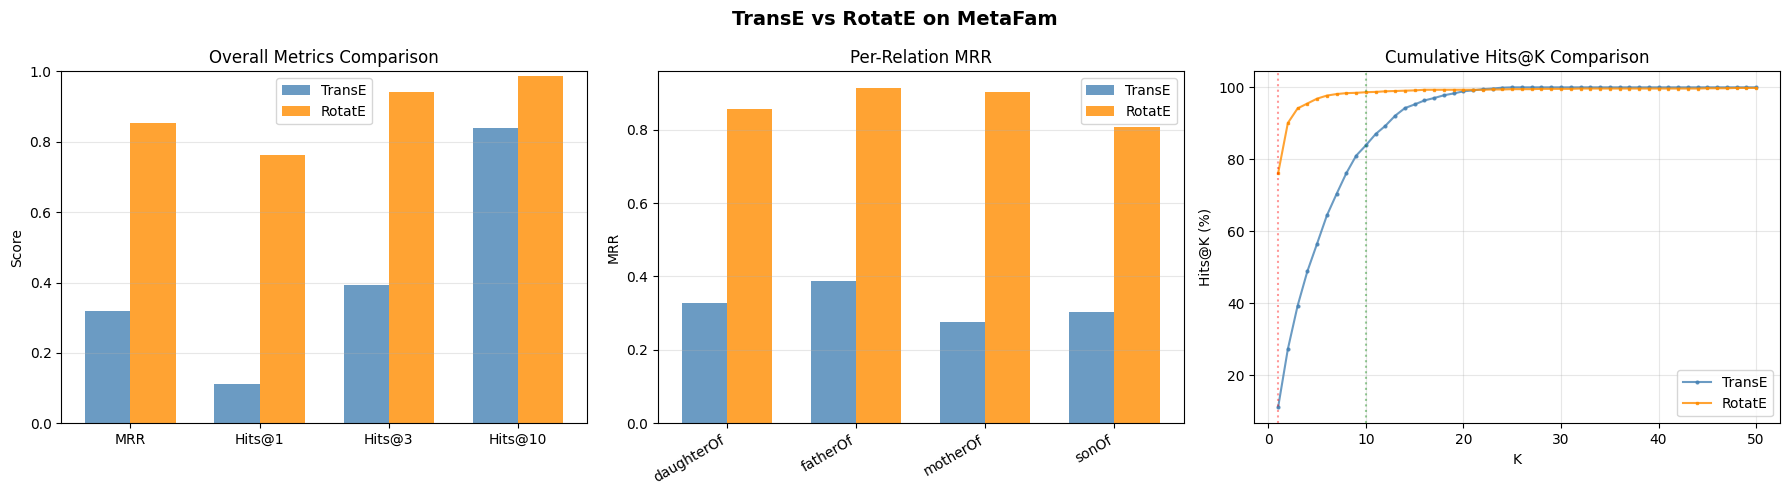

In [16]:
# ========================
# TransE vs RotatE COMPARISON
# ========================

print("="*70)
print("HEAD-TO-HEAD: TransE vs RotatE")
print("="*70)

# Overall comparison table
print(f"\n{'Metric':<12} {'TransE':>10} {'RotatE':>10} {'Δ':>10} {'Winner':>10}")
print("-" * 55)

for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    t_val = overall[m]
    r_val = rotate_overall[m]
    delta = r_val - t_val
    
    if m == 'MR':
        winner = 'RotatE' if r_val < t_val else 'TransE'
        print(f"  {m:<10} {t_val:>8.1f}   {r_val:>8.1f}   {delta:>+8.1f}   {winner:>8}")
    elif m == 'MRR':
        winner = 'RotatE' if r_val > t_val else 'TransE'
        print(f"  {m:<10} {t_val:>8.4f}   {r_val:>8.4f}   {delta:>+8.4f}   {winner:>8}")
    else:
        winner = 'RotatE' if r_val > t_val else 'TransE'
        print(f"  {m:<10} {t_val:>7.2f}%   {r_val:>7.2f}%   {delta:>+7.2f}%   {winner:>8}")

# Per-relation comparison
print(f"\n{'='*70}")
print("PER-RELATION MRR COMPARISON")
print(f"{'='*70}")

print(f"\n{'Relation':<15} {'TransE':>10} {'RotatE':>10} {'Δ MRR':>10} {'Winner':>10}")
print("-" * 58)

for rel in sorted(per_rel.keys()):
    t_mrr = per_rel[rel]['overall']['MRR']
    r_mrr = rotate_per_rel[rel]['overall']['MRR']
    delta = r_mrr - t_mrr
    winner = 'RotatE' if r_mrr > t_mrr else 'TransE'
    print(f"  {rel:<13} {t_mrr:>8.4f}   {r_mrr:>8.4f}   {delta:>+8.4f}   {winner:>8}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Overall metric comparison
metrics = ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']
transe_vals = [overall[m] if m == 'MRR' else overall[m]/100 for m in metrics]
rotate_vals = [rotate_overall[m] if m == 'MRR' else rotate_overall[m]/100 for m in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, transe_vals, width, label='TransE', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, rotate_vals, width, label='RotatE', color='darkorange', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel('Score')
axes[0].set_title('Overall Metrics Comparison')
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Per-relation MRR comparison
rels = sorted(per_rel.keys())
t_mrrs = [per_rel[r]['overall']['MRR'] for r in rels]
r_mrrs = [rotate_per_rel[r]['overall']['MRR'] for r in rels]

x = np.arange(len(rels))
axes[1].bar(x - width/2, t_mrrs, width, label='TransE', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, r_mrrs, width, label='RotatE', color='darkorange', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(rels, rotation=30, ha='right')
axes[1].set_ylabel('MRR')
axes[1].set_title('Per-Relation MRR')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Cumulative Hits@K for both
all_ranks_transe = list(pred_df['head_rank']) + list(pred_df['tail_rank'])
max_k = 50
ks = range(1, max_k + 1)

hits_transe = [np.mean(np.array(all_ranks_transe) <= k) * 100 for k in ks]

# Need to collect RotatE ranks
rotate_model.eval()
rotate_all_ranks = []

with torch.no_grad():
    all_ents_t = torch.arange(n_entities, device=device)
    for i in range(len(test_triples)):
        h, r, t = test_triples[i].tolist()
        
        h_exp = torch.full((n_entities,), h, dtype=torch.long, device=device)
        r_exp = torch.full((n_entities,), r, dtype=torch.long, device=device)
        t_exp = torch.full((n_entities,), t, dtype=torch.long, device=device)
        
        # Tail prediction
        tail_scores = rotate_model.distance(h_exp, r_exp, all_ents_t)
        for known_t in hr_to_t.get((h, r), set()):
            if known_t != t:
                tail_scores[known_t] = float('inf')
        tail_rank = int((tail_scores < tail_scores[t]).sum().item()) + 1
        rotate_all_ranks.append(tail_rank)
        
        # Head prediction
        head_scores = rotate_model.distance(all_ents_t, r_exp, t_exp)
        for known_h in rt_to_h.get((r, t), set()):
            if known_h != h:
                head_scores[known_h] = float('inf')
        head_rank = int((head_scores < head_scores[h]).sum().item()) + 1
        rotate_all_ranks.append(head_rank)

hits_rotate = [np.mean(np.array(rotate_all_ranks) <= k) * 100 for k in ks]

axes[2].plot(ks, hits_transe, 'o-', color='steelblue', markersize=2, 
             linewidth=1.5, label='TransE', alpha=0.8)
axes[2].plot(ks, hits_rotate, 's-', color='darkorange', markersize=2,
             linewidth=1.5, label='RotatE', alpha=0.8)
axes[2].axvline(x=1, color='red', linestyle=':', alpha=0.4)
axes[2].axvline(x=10, color='green', linestyle=':', alpha=0.4)
axes[2].set_xlabel('K')
axes[2].set_ylabel('Hits@K (%)')
axes[2].set_title('Cumulative Hits@K Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('TransE vs RotatE on MetaFam', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

RotatE INVERSE ANALYSIS: Rotation Angles

Inverse Relation Phase Analysis:
  For perfect inverses: θ_R1 + θ_R2 ≈ 0 (mod 2π)
  Measured as: mean |θ_R1 + θ_R2| across dimensions

Pair                                   Mean |θ₁+θ₂|     Max |θ₁+θ₂|    Inverse Quality
----------------------------------------------------------------------------------------
  fatherOf ↔ sonOf                    1.0107 rad       2.9396 rad             POOR
  fatherOf ↔ daughterOf               0.9032 rad       3.1320 rad         MODERATE
  motherOf ↔ sonOf                    1.0569 rad       3.0595 rad             POOR
  motherOf ↔ daughterOf               1.0050 rad       2.8539 rad             POOR

GENDER SEPARATION: Are fatherOf and motherOf different rotations?

  fatherOf vs motherOf phase difference:
    Mean |Δθ|: 1.3790 rad (79.0°)
    Max  |Δθ|: 3.1324 rad (179.5°)

  sonOf vs daughterOf phase difference:
    Mean |Δθ|: 1.2969 rad (74.3°)
    Max  |Δθ|: 3.0382 rad (174.1°)

TransE vs RotatE: Gender S

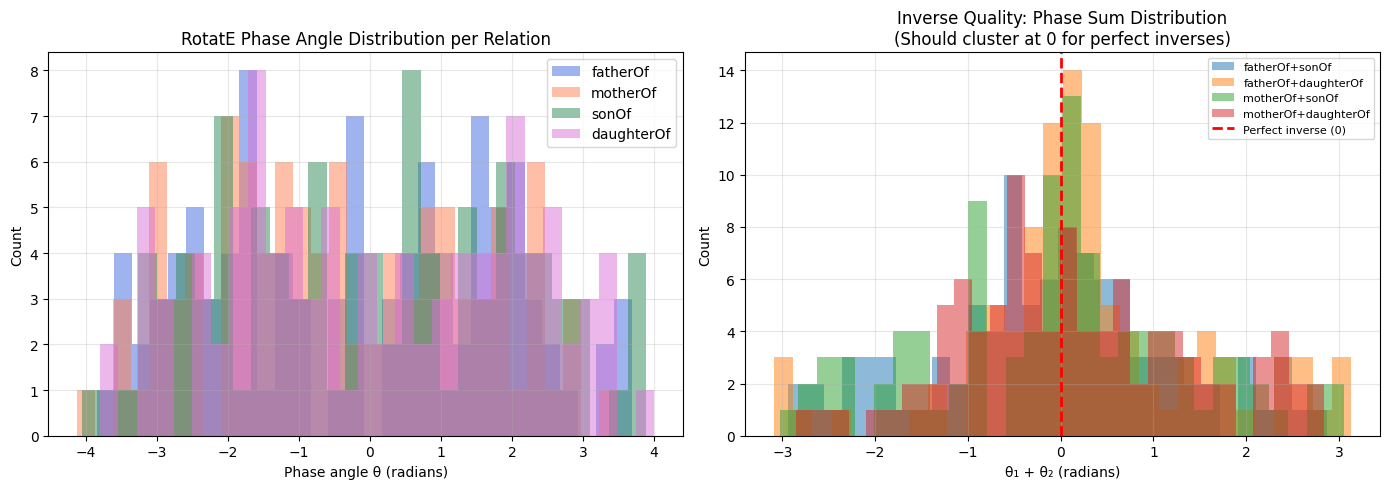

In [17]:
# ========================
# RotatE: INVERSE PATTERN ANALYSIS
# ========================

print("="*70)
print("RotatE INVERSE ANALYSIS: Rotation Angles")
print("="*70)

with torch.no_grad():
    rotate_phases = rotate_model.relation_emb.weight.cpu().numpy()  # phase angles θ

# For inverse relations, RotatE predicts: θ_r1 + θ_r2 = 0 (mod 2π)
# i.e., θ_r2 ≈ -θ_r1

inverse_pairs = [
    ('fatherOf', 'sonOf'),
    ('fatherOf', 'daughterOf'),
    ('motherOf', 'sonOf'),
    ('motherOf', 'daughterOf'),
]

print("\nInverse Relation Phase Analysis:")
print(f"  For perfect inverses: θ_R1 + θ_R2 ≈ 0 (mod 2π)")
print(f"  Measured as: mean |θ_R1 + θ_R2| across dimensions\n")

print(f"{'Pair':<35} {'Mean |θ₁+θ₂|':>15} {'Max |θ₁+θ₂|':>15} {'Inverse Quality':>18}")
print("-" * 88)

for r1, r2 in inverse_pairs:
    θ1 = rotate_phases[rel2id[r1]]
    θ2 = rotate_phases[rel2id[r2]]
    
    # For perfect inverse: θ1 + θ2 = 0 (mod 2π)
    sum_phase = θ1 + θ2
    # Normalize to [-π, π]
    sum_phase = (sum_phase + np.pi) % (2 * np.pi) - np.pi
    
    mean_dev = np.mean(np.abs(sum_phase))
    max_dev = np.max(np.abs(sum_phase))
    quality = "EXCELLENT" if mean_dev < 0.3 else "GOOD" if mean_dev < 0.6 else "MODERATE" if mean_dev < 1.0 else "POOR"
    
    print(f"  {r1} ↔ {r2:<18} {mean_dev:>12.4f} rad {max_dev:>12.4f} rad {quality:>16}")

# Compare fatherOf vs motherOf angles (gender separation)
print(f"\n{'='*70}")
print("GENDER SEPARATION: Are fatherOf and motherOf different rotations?")
print(f"{'='*70}")

θ_father = rotate_phases[rel2id['fatherOf']]
θ_mother = rotate_phases[rel2id['motherOf']]
θ_son = rotate_phases[rel2id['sonOf']]
θ_daughter = rotate_phases[rel2id['daughterOf']]

# Phase difference
father_mother_diff = (θ_father - θ_mother + np.pi) % (2 * np.pi) - np.pi
son_daughter_diff = (θ_son - θ_daughter + np.pi) % (2 * np.pi) - np.pi

print(f"\n  fatherOf vs motherOf phase difference:")
print(f"    Mean |Δθ|: {np.mean(np.abs(father_mother_diff)):.4f} rad ({np.degrees(np.mean(np.abs(father_mother_diff))):.1f}°)")
print(f"    Max  |Δθ|: {np.max(np.abs(father_mother_diff)):.4f} rad ({np.degrees(np.max(np.abs(father_mother_diff))):.1f}°)")

print(f"\n  sonOf vs daughterOf phase difference:")
print(f"    Mean |Δθ|: {np.mean(np.abs(son_daughter_diff)):.4f} rad ({np.degrees(np.mean(np.abs(son_daughter_diff))):.1f}°)")
print(f"    Max  |Δθ|: {np.max(np.abs(son_daughter_diff)):.4f} rad ({np.degrees(np.max(np.abs(son_daughter_diff))):.1f}°)")

# Compare with TransE
print(f"\n{'='*70}")
print("TransE vs RotatE: Gender Separation Comparison")
print(f"{'='*70}")

with torch.no_grad():
    transe_rel_embs = model.relation_emb.weight.cpu().numpy()

from numpy.linalg import norm

def cosine_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-8)

transe_father_mother = cosine_sim(transe_rel_embs[rel2id['fatherOf']], 
                                   transe_rel_embs[rel2id['motherOf']])

print(f"""
  TransE:  fatherOf ↔ motherOf cosine similarity = {transe_father_mother:.4f}
           (Nearly identical! → 50% gender confusion)

  RotatE:  fatherOf ↔ motherOf phase difference   = {np.degrees(np.mean(np.abs(father_mother_diff))):.1f}°
           ({"Different rotations! → better gender distinction" if np.mean(np.abs(father_mother_diff)) > 0.1 else "Similar rotations → still confusing gender"})
""")

# Visualize relation phases
plt.figure(figsize=(14, 5))

focus_rels = ['fatherOf', 'motherOf', 'sonOf', 'daughterOf']
colors = ['royalblue', 'coral', 'seagreen', 'orchid']

# Phase distribution across dimensions
for i, rel in enumerate(focus_rels):
    θ = rotate_phases[rel2id[rel]]
    plt.subplot(1, 2, 1)
    plt.hist(θ, bins=30, alpha=0.5, label=rel, color=colors[i])

plt.xlabel('Phase angle θ (radians)')
plt.ylabel('Count')
plt.title('RotatE Phase Angle Distribution per Relation')
plt.legend()
plt.grid(True, alpha=0.3)

# Pairwise phase sums (inverse quality)
plt.subplot(1, 2, 2)
for r1, r2 in inverse_pairs:
    θ1 = rotate_phases[rel2id[r1]]
    θ2 = rotate_phases[rel2id[r2]]
    sum_phase = (θ1 + θ2 + np.pi) % (2 * np.pi) - np.pi
    plt.hist(sum_phase, bins=30, alpha=0.5, 
             label=f'{r1}+{r2}')

plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Perfect inverse (0)')
plt.xlabel('θ₁ + θ₂ (radians)')
plt.ylabel('Count')
plt.title('Inverse Quality: Phase Sum Distribution\n(Should cluster at 0 for perfect inverses)')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html
!pip install torchdata

Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in links: https://data.dgl.ai/wheels/torch-2.1/repo.html


In [28]:
!pip install torchdata==0.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.10.1 which is incompatible.


In [29]:
!pip install --upgrade dgl


In [31]:
# Run this FIRST, before importing DGL
!pip install torchdata==0.7.1 --quiet
!pip install dgl -f https://data.dgl.ai/wheels/repo.html --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 3.6 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.7.1 which is incompatible.


In [30]:
# ========================
# R-GCN SETUP
# ========================

# Install DGL if needed (uncomment the right line for your environment)
# !pip install dgl -f https://data.dgl.ai/wheels/torch-2.1/repo.html
# For Kaggle with CPU:
# !pip install dgl -f https://data.dgl.ai/wheels/repo.html

import dgl
from dgl.nn.pytorch import RelGraphConv

print("="*70)
print("R-GCN: RELATIONAL GRAPH CONVOLUTIONAL NETWORK")
print("="*70)

print("""
ARCHITECTURE DIFFERENCE:
━━━━━━━━━━━━━━━━━━━━━━━
TransE/RotatE (KG Embeddings):
  Each entity gets a FIXED vector, learned independently.
  olivia0's embedding knows nothing about her neighbors.

R-GCN (Graph Neural Network):
  Each entity's embedding is COMPUTED by aggregating neighbors.
  olivia0's embedding incorporates info from parents, siblings, children.
  
  Layer 1: olivia0 ← info from direct neighbors (parents, siblings)
  Layer 2: olivia0 ← info from 2-hop neighbors (grandparents, cousins)

SCORING FUNCTION:
  R-GCN produces node embeddings → DistMult decoder scores triples
  DistMult: score(h, r, t) = Σ hᵢ · rᵢ · tᵢ
  
  Note: DistMult is SYMMETRIC (score(h,r,t) = score(t,r,h))
  This is a known limitation, but the GNN encoder can learn 
  ASYMMETRIC node representations to partially compensate.
""")

# ========================
# BUILD DGL GRAPH
# ========================

# Key trick from reference: ADD REVERSE EDGES
# GNN message passing is directional. Without reverse edges,
# information only flows from head → tail.
# Adding reverse edges lets info flow BOTH directions.

src = train_triples[:, 0]      # head entities
dst = train_triples[:, 2]      # tail entities
rel = train_triples[:, 1]      # relations

# Bidirectional: add reverse edges with NEW relation types
# Original relations: 0..27
# Reverse relations:  28..55
src_all = torch.cat([src, dst])
dst_all = torch.cat([dst, src])
rel_all = torch.cat([rel, rel + n_relations])

# Build DGL graph
g = dgl.graph((src_all, dst_all), num_nodes=n_entities)
g.edata['etype'] = rel_all

# Edge normalization (prevents high-degree nodes from dominating)
# norm = 1 / in_degree_per_relation_type
g.edata['norm'] = dgl.norm_by_dst(g).unsqueeze(-1)

n_rels_total = n_relations * 2  # 28 original + 28 reverse = 56

print(f"DGL Graph constructed:")
print(f"  Nodes: {g.num_nodes()}")
print(f"  Edges: {g.num_edges()} ({len(train_triples)} original + {len(train_triples)} reverse)")
print(f"  Relation types: {n_rels_total} ({n_relations} original + {n_relations} reverse)")
print(f"  Avg degree: {g.num_edges() / g.num_nodes():.1f}")

# Verify graph is connected
print(f"\n  Graph has {dgl.batch([g]).batch_size} component(s)")
print(f"  Self-loops: {(src_all == dst_all).sum().item()}")

ModuleNotFoundError: No module named 'torchdata.datapipes'